## Evaluation

##### How to run:

Run all cells up to, and including, the loading data section.

Before running the evaluation, comment out function calls, dataset loading, and test code in the files for the recommenders (feature_based.ipynb or item_collab_filtering.ipynb).
Run all cells in the section belonging to the recommender you want to evaluate.


## Required packages:

##### All:
 - pandas
 - numpy
 - scikit-learn

##### Collaborative Filtering:
 - pyspark

In [ ]:
# import libraries

import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score
from datetime import datetime as datetime

#### Defining Helper Functions

In [ ]:
# Get all impressions from a specific user in a behavior dataframe, and add them to a new dataframe
def get_impressions(userID, behavior_view):
    test = []
    for index, row in behavior_view.iterrows():
        if row["User ID"] == userID:
            for impression in row["Impressions"].split(" "):
                imp = impression.split("-")
                if imp[1] == "1":
                    test.append((imp[0], 1))
                else:
                    test.append((imp[0], 0))
    return pd.DataFrame(test, columns=["News ID", "Response"])


# Get df of all user IDs
def get_users(view1, view2):
    return pd.merge(left=view1["User ID"], right=view2["User ID"], how="inner", on="User ID")["User ID"].unique()

# Get a timegated view of a behavior dataframe
def get_view(behavior, t0, t1):
    df = behavior[(behavior["Timestamp"] >= t0) & (behavior["Timestamp"] < t1)]
    return df

#### Loading Data

In [22]:
behavior = pd.read_csv("data/MINDsmall_train/behaviors.tsv", sep="\t", header=None, names=["Impression ID", "User ID", "Time", "History", "Impressions"])
news = pd.read_csv("data/MINDsmall_train/news.tsv", sep="\t", header=None, names=["News ID", "Category", "Subcategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities", "Title Topics", "Abstract Topics"])

In [23]:
def str_to_timestamp(str):
    return datetime.strptime(str, "%m/%d/%Y %H:%M:%S %p").timestamp()

timestamps = behavior["Time"].apply(str_to_timestamp)
behavior["Timestamp"] = timestamps
behavior.sort_values(by="Timestamp")

#Fill missing abstracts with placeholder
news['Abstract'].fillna('No abstract available', inplace=True)

# if there are rows with no impressions, drop them
behavior = behavior.dropna(subset=['Impressions']) # this looses some user information, could instead manually overwrite and fill in the missing values based on the typo combining the impression and history columns

C:\Users\Bruker\AppData\Local\Temp\ipykernel_9640\3025606149.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  news['Abstract'].fillna('No abstract available', inplace=True)


#### Evaluate Feature-Based Model

In [19]:
# Importing functions from feature_based.ipynb
# Comment out function calls in feature_based.ipynb (except the pd.set_option calls) before running this field
%run feature_based.ipynb

In [64]:
X_j, news_id_to_index = create_all_item_vectors(news)

evaluations_ndcg = []
evaluations_pak = []

t0 = float(behavior["Timestamp"][0])
tn = float(behavior["Timestamp"][len(behavior["Timestamp"])-1])

split_ratio = 85/100
dt = (tn-t0)/5
k = 5

In [65]:
# Loop that runs the sliding window

while t0 <= tn-dt:
    # Splitting into train and test views
    tsplit = t0 + dt*split_ratio
    t1 = t0 + dt

    train_view = get_view(behavior, t0, tsplit)
    test_view = get_view(behavior, tsplit, t1)

    # Finding users that have impressions in both the test and train view
    users = get_users(test_view, train_view)

    for user in users:
        prediction = pd.DataFrame(find_top_k_articles(user, X_j, 600000, news_id_to_index, train_view), columns=["News ID", "Score"])
        response = get_impressions(user, test_view)
        
        pred_resp = prediction.join(response.set_index("News ID"), on="News ID", how="inner")

        try:
            evaluation = ndcg_score(np.array([pred_resp["Response"].to_numpy()]), np.array([pred_resp["Score"].to_numpy()]))
            evaluations_ndcg.append(evaluation)
            k_slice = pred_resp["Response"].iloc[:k]
            evaluation = k_slice.sum()/min(len(k_slice), k)
            evaluations_pak.append(evaluation)
            #print("Predictions for user " + user + " evaluated!")
        except:
            #print("Eval failed")
            pass
        

    print("moving timeframe")
    t0 = tsplit

moving timeframe
moving timeframe
moving timeframe
moving timeframe
moving timeframe


In [67]:
print("nDCG:")
print(sum(evaluations_ndcg)/len(evaluations_ndcg))
print(evaluations_ndcg)
print("Precision at K:")
print(sum(evaluations_pak)/len(evaluations_pak))
print(evaluations_pak)

nDCG:
0.4571730241297533
[0.5802792108518124, 0.3978088012057571, 0.8772153153380493, 0.25, 1.0, 0.35620718710802235, 0.20801459767650954, 0.5, 0.3010299956639808, 0.3016489773220472, 0.5, 0.6309297535714573, 0.35620718710802235, 0.6475814929610743, 0.3010299956639808, 0.30902565941063875, 0.30852755538171533, 0.3154648767857289, 1.0, 0.31971770301599084, 0.7631539858737962, 0.5, 0.6309297535714573, 0.1999999999999993, 0.677935239641392, 1.0, 0.6309297535714573, 1.0, 0.45560514958746057, 0.3846743632171773, 0.4035609685202446, 0.1599093207512685, 0.1771838201355571, 0.38546288150392977, 0.1854490234153694, 0.23981246656813138, 0.3192543968641966, 1.0, 0.5, 0.27894294565112965, 0.44414570333770237, 0.35771793422508685, 1.0, 0.2702381544273198, 0.44734633595710144, 0.5, 0.40335063772832164, 0.4326023979964297, 0.4220702428210776, 0.4404894581342411, 0.19823986317055997, 0.5, 0.27329125012756833, 0.3894405208858823, 0.6934264036172708, 0.25055968033607784, 0.3333333333333335, 0.6586370323

#### Evaluate Collaborative Filtering Model

In [77]:
# Importing functions from item_collab_filtering.ipynb
# Comment out function calls (except for the call to initiate a spark engine) in item_collab_filtering.ipynb before running this field
%run item_collab_filtering.ipynb

In [78]:
evaluations_ndcg = []
evaluations_pak = []
t0 = float(behavior["Timestamp"][0])
tn = float(behavior["Timestamp"][len(behavior["Timestamp"])-1])
split_ratio = 85/100
dt = (tn-t0)/5
k = 5

In [79]:
# Loop that runs the sliding window

while t0 <= tn-dt:
    # Splitting into train and test views
    tsplit = t0 + dt*split_ratio
    t1 = t0 + dt

    train_view = get_view(behavior, t0, tsplit)
    test_view = get_view(behavior, tsplit, t1)

    # Finding users that have impressions in both the test and train view
    users = get_users(test_view, train_view)

    # Train the model
    model = train_collaborative_filtering_model(train_view)

    # Can swap which for loop you iterate through, if iterating over all users takes too long
    #for user in users[:500]:
    for user in users:
        spark_prediction = get_top_n_recommendations(user, model, N=600000)
        prediction = spark_prediction.toPandas()
        
        spark_prediction.unpersist()
        
        response = get_impressions(user, test_view)
        pred_resp = prediction.join(response.set_index("News ID"), on="news_id", how="inner")
        try:
            evaluation = ndcg_score(np.array([pred_resp["Response"].to_numpy()]), np.array([pred_resp["score"].to_numpy()]))
            evaluations_ndcg.append(evaluation)
            k_slice = pred_resp["Response"].iloc[:k]
            evaluation = k_slice.sum()/min(len(k_slice), k)
            evaluations_pak.append(evaluation)
            #print("Predictions for user " + user + " evaluated!")
        except:
            #print("Eval failed")
            pass

    print("moving timeframe")
    spark.catalog.clearCache()
    t0 = tsplit

Py4JJavaError: An error occurred while calling o116.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 1.0 failed 1 times, most recent failure: Lost task 4.0 in stage 1.0 (TID 12) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 34 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 34 more


In [ ]:
print("nDCG:")
print(sum(evaluations_ndcg)/len(evaluations_ndcg))
print("Precision at K:")
print(sum(evaluations_pak)/len(evaluations_pak))

#### Checking against randomized scores

In [68]:
evaluations_ndcg = []
evaluations_pak = []
t0 = float(behavior["Timestamp"][0])
tn = float(behavior["Timestamp"][len(behavior["Timestamp"])-1])
split_ratio = 85/100
dt = (tn-t0)/5
k = 5
np.random.seed(42)

In [69]:
# Loop that runs the sliding window

while t0 <= tn-dt:
    # Splitting into train and test views
    tsplit = t0 + dt*split_ratio
    t1 = t0 + dt

    train_view = get_view(behavior, t0, tsplit)
    test_view = get_view(behavior, tsplit, t1)

    # Finding users that have impressions in both the test and train view
    users = get_users(test_view, train_view)


    # Get ranked recommendations, and evaluate them for all users
    for user in users:
        pred_resp = get_impressions(user, test_view)
        pred_resp["Score"] = np.random.random(pred_resp["Response"].size)
        try:
            evaluation = ndcg_score(np.array([pred_resp["Response"].to_numpy()]), np.array([pred_resp["Score"].to_numpy()]))
            evaluations_ndcg.append(evaluation)
            k_slice = pred_resp["Response"].iloc[:k]
            evaluation = k_slice.sum()/min(len(k_slice), k)
            evaluations_pak.append(evaluation)
            #print("Predictions for user " + user + " evaluated!")
        except:
            #print("Eval failed")
            pass

    print("moving timeframe")
    t0 = tsplit

moving timeframe
moving timeframe
moving timeframe
moving timeframe
moving timeframe


In [70]:
print("nDCG:")
print(sum(evaluations_ndcg)/len(evaluations_ndcg))
print("Precision at K:")
print(sum(evaluations_pak)/len(evaluations_pak))

nDCG:
0.41270944973271695
Precision at K:
0.10716804407713323


#### Tuning Sliding Window

In [57]:
t0 = float(behavior["Timestamp"][0])
tn = float(behavior["Timestamp"][len(behavior["Timestamp"])-1])
split_ratios = [i/100 for i in range(50,100)]
dts = [(tn-t0)/n for n in range(5,10)]

In [25]:
counts = []
sizes = []
for dt in dts:
    aggregate_counts = []
    aggregate_sizes = []
    for split_ratio in split_ratios:
        user_counts = []
        train_sizes = []
        start_time = t0
        while start_time <= tn-dt:
            tsplit = start_time + dt*split_ratio
            t1 = start_time + dt
            train_view = get_view(behavior, start_time, tsplit)
            test_view = get_view(behavior, tsplit, t1)

            user_count = len(get_users(train_view, test_view))
            user_counts.append(user_count)

            train_size = len(train_view)
            train_sizes.append(train_size)

            start_time = tsplit
        aggregate_counts.append(sum(user_counts)/len(user_counts))
        aggregate_sizes.append(sum(train_sizes)/len(train_sizes))
    counts.append(aggregate_counts)
    sizes.append(aggregate_sizes)



In [26]:
print(counts)
print(sizes)

[[847.7777777777778, 964.0, 940.125, 897.5, 896.75, 880.75, 804.875, 867.75, 1056.4285714285713, 1045.857142857143, 1008.1428571428571, 992.2857142857143, 968.4285714285714, 912.4285714285714, 817.1428571428571, 671.0, 628.8571428571429, 735.0, 750.5, 746.3333333333334, 692.8333333333334, 723.6666666666666, 770.8333333333334, 791.1666666666666, 745.8333333333334, 686.5, 628.5, 563.6666666666666, 438.5, 426.8333333333333, 446.3333333333333, 552.6, 575.0, 592.0, 599.4, 605.0, 597.0, 579.4, 530.6, 498.2, 467.8, 462.2, 464.4, 451.8, 434.4, 371.2, 330.8, 265.2, 100.8, 50.2], [758.5454545454545, 806.6, 778.0, 797.5, 809.1, 801.2, 880.2222222222222, 834.8888888888889, 770.3333333333334, 717.7777777777778, 721.2222222222222, 727.8888888888889, 702.8888888888889, 729.5, 710.875, 687.625, 641.875, 566.25, 604.0, 649.875, 672.875, 692.25, 805.2857142857143, 844.4285714285714, 871.1428571428571, 837.8571428571429, 765.8571428571429, 654.0, 516.5714285714286, 463.2857142857143, 442.85714285714283, 

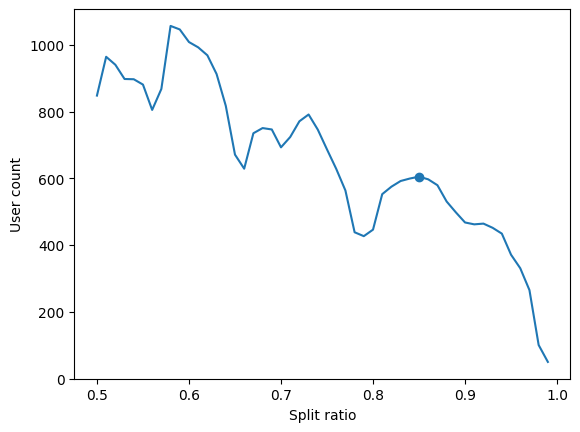

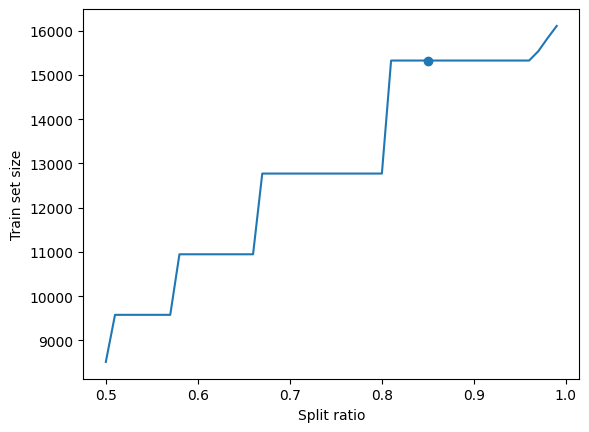

35
605.0


In [75]:
import matplotlib.pyplot as plt

x = [i/100 for i in range(50,100)]
plt.figure(0)
plt.plot(x, counts[0])
plt.ylabel("User count")
plt.xlabel("Split ratio")
plt.scatter((35+50)/100, counts[0][35])
plt.show()

plt.figure(1)
plt.plot(x, sizes[0])
plt.ylabel("Train set size")
plt.xlabel("Split ratio")
plt.scatter((35+50)/100, sizes[0][35])
plt.show()

print(counts[0].index(max(counts[0][80-50:90-50])))
print(counts[0][35])